# AutoML Regression Modelling with PyCaret

In [1]:
"""
See the last cell for the runtime dependencies of this notebook.

Run these cells one by one the first time to understand how a CSV is generated for a single judge
    1. the data is loaded from the csv
    2. the data is split on judges
    3. only drugs, statut 893 is considered as thats what we have enough data to work with
    4. many models are trained by judge
    5. the best model is selected and tuned
    6. the best model is used to predict on all available data and RMSE noted
    7. offline predictions are made for variations of input variables 
    8. Finally all 3 CSV's from preceding step are combined into one circuit6_3judges-893-predictions.csv
"""

RUNONCE=False

import pandas as pd
from pycaret.regression import *
from datetime import datetime, date
%matplotlib inline

sen = pd.read_csv("./circuit6_top3judges_cleaned.csv")
judges = ["ANDREWS,M","QUESADA,F","PETERS,R"]
dfs = sen[sen["statut"].str.startswith("893", na=False)]
dfs = [ dfs[dfs.judge == judges[0]], \
        dfs[dfs.judge == judges[1]], \
        dfs[dfs.judge == judges[2]] ]

In [2]:

#TODO: do for judge 0,1,2
judge=0
d = dfs[judge]
print(f"total: {len(d)}")

total: 2915


In [3]:
d = d[['sp_cj_total_days', 'gender', 'age', 'race', 'circuit', 'totpts_cut_group', 'clfely', 'totpts_cut_range', 'judge']]

data = d.sample(frac=0.9, random_state=786)
data_unseen = d.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2624, 9)
Unseen Data For Predictions: (291, 9)


In [4]:
from pycaret.regression import *
X = setup(data = data, target = 'sp_cj_total_days', session_id=123, normalize = True, 
          transformation = True, #transform_target = True,
          ignore_features = ['totpts_cut_range', 'judge', 'circuit']
          )


,Description,Value
0,session_id,123
1,Target,sp_cj_total_days
2,Original Data,"(2624, 9)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1836, 25)"


In [5]:
best = compare_models(exclude = [])
"""
	Model	MAE	MSE	RMSE	R2	RMSLE	MAPE	TT (Sec)
	Ridge Regression	157.9404	106281.4253	315.6947	0.5543	3.1986	1.0991	0.1900
	Ridge Regression	105.4253	30369.5737	165.6498	0.5911	3.0792	0.4659	0.0100
	Huber Regressor	97.2356	82937.9975	259.3400	0.6477	2.3419	1.0983	0.0230
"""

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,157.9404,106281.4253,315.6947,0.5543,3.1986,1.0991,0.1600
lasso,Lasso Regression,158.8009,115204.3010,326.8646,0.5238,3.1943,1.0832,0.1630
huber,Huber Regressor,151.3408,118156.3738,331.5084,0.5079,2.8378,0.9890,0.0180
br,Bayesian Ridge,159.4810,114435.4798,327.5961,0.5008,3.1897,1.0811,0.0080
lr,Linear Regression,159.4901,114289.7432,327.4072,0.4979,3.1887,1.0801,0.3850
lightgbm,Light Gradient Boosting Machine,169.9745,123142.1785,339.7915,0.4846,3.1750,1.6294,0.6660
rf,Random Forest Regressor,171.6450,121597.0995,341.5749,0.4718,3.1062,1.8813,0.1040
knn,K Neighbors Regressor,172.3346,124384.8029,344.4876,0.4685,3.1085,1.2570,0.0220
gbr,Gradient Boosting Regressor,165.4280,121194.1681,339.5136,0.4667,3.2408,1.1119,0.0190
par,Passive Aggressive Regressor,149.5904,134681.0418,352.4566,0.4526,2.4745,0.9194,0.0090


'\n\tModel\tMAE\tMSE\tRMSE\tR2\tRMSLE\tMAPE\tTT (Sec)\n\tRidge Regression\t157.9404\t106281.4253\t315.6947\t0.5543\t3.1986\t1.0991\t0.1900\n\tRidge Regression\t105.4253\t30369.5737\t165.6498\t0.5911\t3.0792\t0.4659\t0.0100\n\tHuber Regressor\t97.2356\t82937.9975\t259.3400\t0.6477\t2.3419\t1.0983\t0.0230\n'

In [6]:
tuned = tune_model(best)
final = finalize_model(tuned)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,186.2352,327055.1553,571.8874,0.4220,3.3798,0.7609
1,154.4770,74624.4738,273.1748,0.6406,3.3099,2.6005
2,147.7557,74223.6519,272.4402,0.5698,3.0891,0.5407
3,136.4231,46039.5347,214.5683,0.7182,3.3015,0.7808
4,159.2115,79650.1396,282.2236,0.5496,3.1754,0.7899
5,154.3294,82533.3211,287.2861,0.6207,3.1293,2.3047
6,179.0992,128584.2259,358.5864,0.4231,3.3599,0.6275
7,138.9650,72148.8665,268.6054,0.6058,3.0369,0.6354
8,179.6406,103855.5303,322.2662,0.4074,3.1395,0.8358
9,165.2211,124383.0682,352.6798,0.4953,3.3155,1.3197


In [7]:
print(final)

Ridge(alpha=2.81, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=True, random_state=123, solver='auto', tol=0.001)


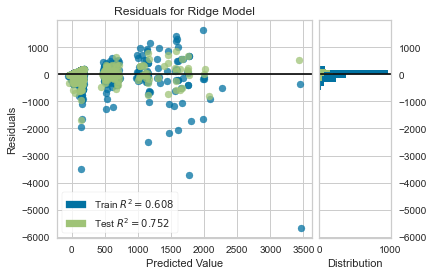

In [8]:
plot_model(final)

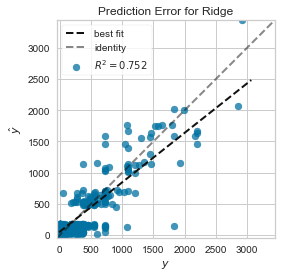

In [9]:
plot_model(final, plot = 'error')

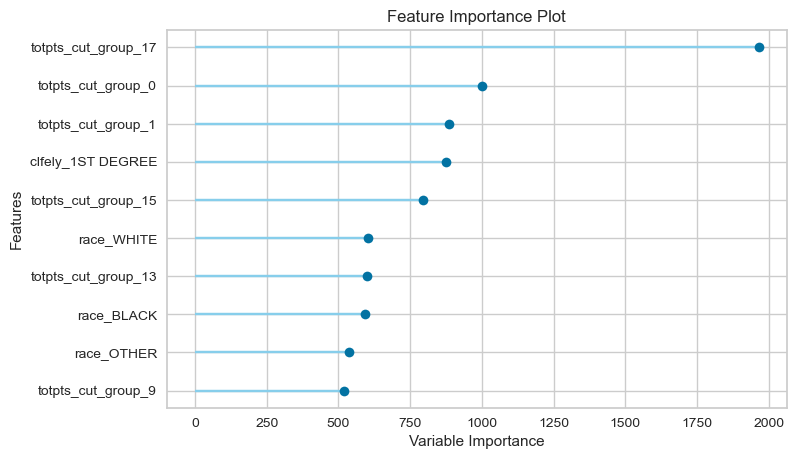

In [10]:
plot_model(final, plot='feature')

In [11]:
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,128.0167,34811.2620,186.5778,0.7522,3.2479,0.9540


In [12]:
unseen_predictions = predict_model(final, data=data_unseen)
from pycaret.utils import check_metric
rmse = check_metric(unseen_predictions.sp_cj_total_days, unseen_predictions.Label, 'RMSE')
rmse

177.6765

In [13]:
check_metric(unseen_predictions[unseen_predictions.race=="BLACK"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="BLACK"].Label, 'R2')

0.7111

In [14]:
check_metric(unseen_predictions[unseen_predictions.race=="WHITE"].sp_cj_total_days, unseen_predictions[unseen_predictions.race=="WHITE"].Label, 'R2')

0.6111

<AxesSubplot:>

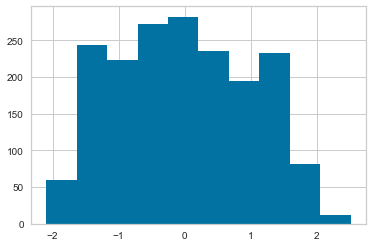

In [15]:
get_config('X_train').shape
get_config('X_test').dtypes
get_config('X_train').age.hist()

In [16]:
preds = None

if (not RUNONCE):
    RUNONCE = True
    
    zipped_lists = zip(data_unseen.totpts_cut_range.unique(), data_unseen.totpts_cut_group.unique())
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [ list(tuple) for tuple in  tuples]
    k={v:i for i,v in enumerate(list2)}

    """
    TODO: This block takes a while to run but only needs to be run once and after that convert to a raw block
    The preds variable can be reused for the 8 other runs
    """

    r = pd.Series(0, index=data_unseen.columns)
    preds = pd.DataFrame(columns=data_unseen.columns)

    for age in range(20,86):
        for gender in ("MALE","FEMALE"):
            for race in ["BLACK", "WHITE"]:
                for ptsgrp in range(0,18):
                    for fly in ["1ST DEGREE", "1ST/LIFE", "2ND DEGREE", "3RD DEGREE", "LIFE"]:
                        row=r.copy()
                        row[list(data_unseen.columns)] = \
                            [0, gender, age, race, "",ptsgrp,fly,list1[k[ptsgrp]]]
                        preds = preds.append(row, ignore_index=True)
                    
len(preds)

In [18]:
final = predict_model(final, data=preds.copy(deep=True))
final.rename(columns = {'Label':'predicted_sentence_days'}, inplace = True)
final["error_margin_days"]=rmse
final["crime"]="trafficking/893"
final["judge"]=judges[judge]
final.to_csv(f"./{judges[judge]}_893.csv",index=False)
final

,sp_cj_total_days,gender,age,race,circuit,totpts_cut_group,clfely,totpts_cut_range,judge,predicted_sentence_days,error_margin_days,crime
0,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,1ST DEGREE,"(0.0, 22.0]","ANDREWS,M",451.716919,177.6765,trafficking/893
1,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,1ST/LIFE,"(0.0, 22.0]","ANDREWS,M",451.716919,177.6765,trafficking/893
2,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,2ND DEGREE,"(0.0, 22.0]","ANDREWS,M",-4.377075,177.6765,trafficking/893
3,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,3RD DEGREE,"(0.0, 22.0]","ANDREWS,M",17.550232,177.6765,trafficking/893
4,0,MALE,20,BLACK,CIRCUIT 06 - CLEARWATER,0,LIFE,"(0.0, 22.0]","ANDREWS,M",451.716919,177.6765,trafficking/893
...,...,...,...,...,...,...,...,...,...,...,...,...
23755,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,1ST DEGREE,"(164.0, 174.0]","ANDREWS,M",3449.598633,177.6765,trafficking/893
23756,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,1ST/LIFE,"(164.0, 174.0]","ANDREWS,M",3449.598633,177.6765,trafficking/893
23757,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,2ND DEGREE,"(164.0, 174.0]","ANDREWS,M",2993.504395,177.6765,trafficking/893
23758,0,FEMALE,85,WHITE,CIRCUIT 06 - CLEARWATER,17,3RD DEGREE,"(164.0, 174.0]","ANDREWS,M",3015.431885,177.6765,trafficking/893


In [19]:
pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
affinegap                          1.12
aif360                             0.4.0
alabaster                          0.7.12
alembic                            1.7.5
altair                             4.1.0
anaconda-client                    1.7.2
anaconda-navigator                 2.1.1
anaconda-project                   0.9.1
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argcomplete                        1.12.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2
async-generator                    1.10
atomicwrites                       1.4.0
a